<a href="https://colab.research.google.com/github/ritwiks9635/New_Project_Ideas/blob/main/DCGAN_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCGAN-Using Pytorch**

In [ ]:
! unzip /content/https:/www.kaggle.com/datasets/jessicali9530/celeba-dataset/celeba-dataset.zip

In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = "/content/img_align_celeba"
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR + "/img_align_celeba")[:10])

['img_align_celeba']
['002403.jpg', '147271.jpg', '052014.jpg', '138220.jpg', '176871.jpg', '034524.jpg', '097165.jpg', '136839.jpg', '066974.jpg', '062149.jpg']


In [5]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

#**Load And Preprocessing Data**

In [6]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR,
    transform = T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)]))


train_dataloader = DataLoader(train_ds, batch_size,  shuffle = True, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def de_norm(img_tensor):
    return img_tensor * stats[0][0] + stats[1][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(de_norm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(data, nmax=64):
    for images, _ in data:
        show_images(images, nmax)
        break

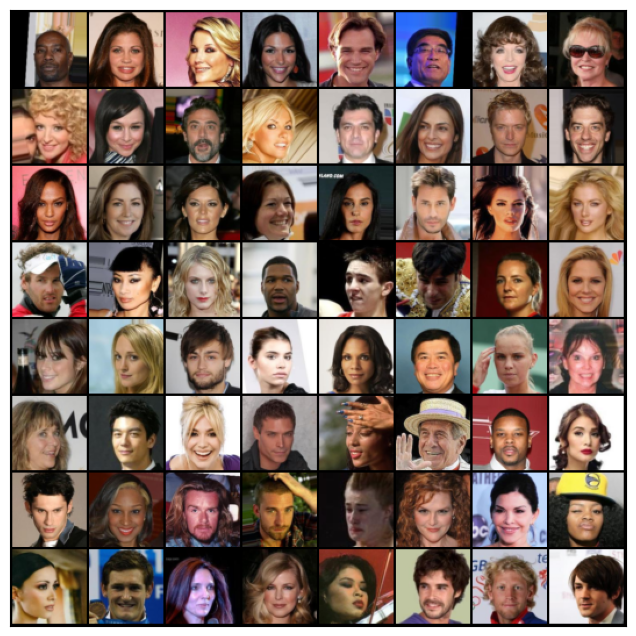

In [11]:
show_batch(train_dataloader)

##**Build GPU Device**

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
print(device)

cuda


In [14]:
train_loader = DeviceDataLoader(train_dataloader, device)

In [15]:
import torch.nn as nn

#**Build Generator Network**

In [16]:
discriminator = nn.Sequential(

        # in: 3 x 64 x 64
        nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),

        # out: 64 x 32 x 32
        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        # out: 128 x 16 x 16
        nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        #out: 256 x 8 x 8
        nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),

        # out: 512 x 4 x 4
        nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

        # out 1 x 1 x 1
        nn.Flatten(),
        nn.Sigmoid())

In [19]:
discriminator = to_device(discriminator, device)

#**Build Generator Network**

In [20]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1 or 128 x 1 x 1)
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # out: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # out: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh())
    #out: 3 x 64 x 64

torch.Size([64, 3, 64, 64])


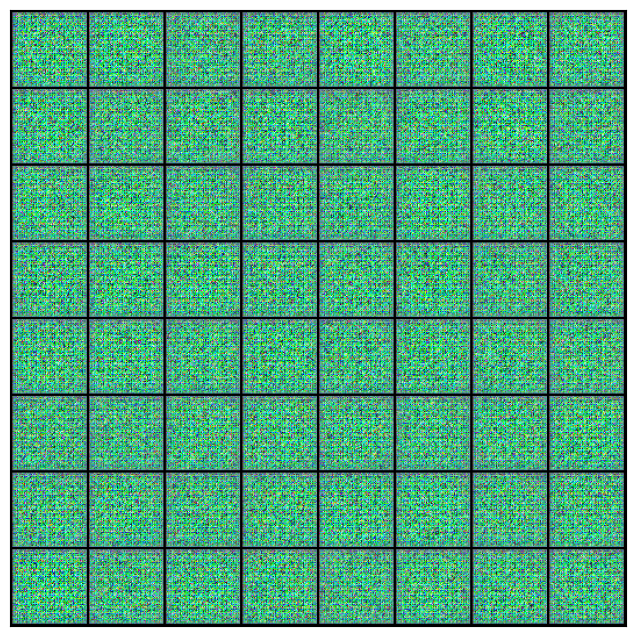

In [22]:
fimg = torch.randn(batch_size, latent_size, 1, 1) # random tensor
fake_img = generator(fimg)
print(fake_img.shape)
show_images(fake_img)

In [23]:
generator = to_device(generator, device)

#**Build Generator for Training**

In [24]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#**Build Generator for Training**

In [25]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [26]:
from torchvision.utils import save_image


sample_dir = 'generated_img'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(de_norm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
rand_img = torch.randn(batch_size, latent_size, 1, 1, device = device)

Saving generated-images-0000.png


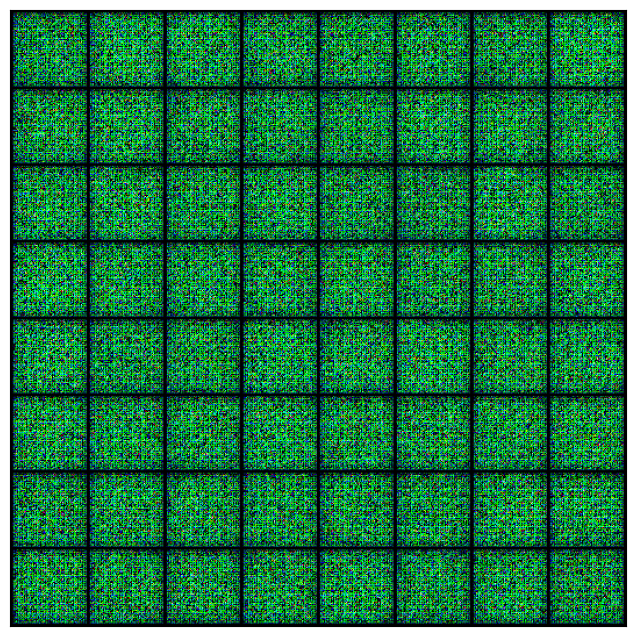

In [29]:
save_samples(0, rand_img)

#**Full Training Loop**

In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, rand_img, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [32]:
history = fit(epochs = 10, lr = 0.0002)

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.6069, loss_d: 0.7450, real_score: 0.9653, fake_score: 0.4298
Saving generated-images-0001.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 4.7436, loss_d: 0.1878, real_score: 0.9795, fake_score: 0.1473
Saving generated-images-0002.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.0796, loss_d: 0.2831, real_score: 0.9526, fake_score: 0.1684
Saving generated-images-0003.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.1526, loss_d: 0.1016, real_score: 0.9237, fake_score: 0.0148
Saving generated-images-0004.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 4.0576, loss_d: 0.1312, real_score: 0.9579, fake_score: 0.0417
Saving generated-images-0005.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.1340, loss_d: 0.1341, real_score: 0.9061, fake_score: 0.0253
Saving generated-images-0006.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 4.9503, loss_d: 0.0500, real_score: 0.9768, fake_score: 0.0246
Saving generated-images-0007.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.4829, loss_d: 0.0949, real_score: 0.9444, fake_score: 0.0312
Saving generated-images-0008.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.1406, loss_d: 0.7415, real_score: 0.6045, fake_score: 0.0049
Saving generated-images-0009.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.1201, loss_d: 0.0436, real_score: 0.9840, fake_score: 0.0263
Saving generated-images-0010.png


#**Evaluate & Predict**

In [33]:
losses_g, losses_d, real_scores, fake_scores = history

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [35]:
from IPython.display import Image

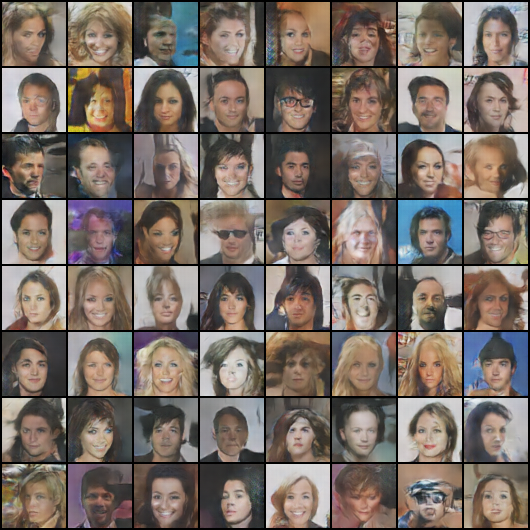

In [36]:
Image('/content/generated_img/generated-images-0007.png')